In [1]:
#all the following procedure took base from :
#https://www.kaggle.com/code/shubhamcodez/rsna-efficientnet-starter-notebook/notebook

import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm

In [2]:
root = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
train  = pd.read_csv(root + 'train.csv')
label = pd.read_csv(root + 'train_label_coordinates.csv')
train_desc  = pd.read_csv(root + 'train_series_descriptions.csv')
test_desc   = pd.read_csv(root + 'test_series_descriptions.csv')
sub         = pd.read_csv(root + 'sample_submission.csv')
conditions = {}

In [3]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

In [4]:
train_image_paths = generate_image_paths(train_desc, f'{root}/train_images')
test_image_paths = generate_image_paths(test_desc, f'{root}/test_images')

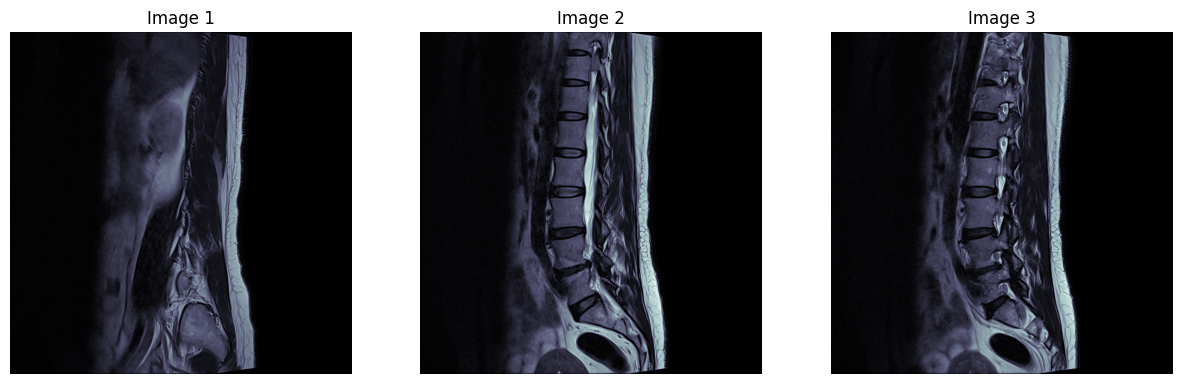

In [5]:
def display_dicom_images(image_paths):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    for i, path in enumerate(image_paths[:3]):
        ds = pydicom.dcmread(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Display the first three DICOM images
display_dicom_images(train_image_paths)

In [6]:
def reshape_row(row):
    data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
            data['study_id'].append(row['study_id'])
            data['condition'].append(condition)
            data['level'].append(level)
            data['severity'].append(value)
    
    return pd.DataFrame(data)

# Reshape the DataFrame for all rows
train = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)

In [7]:
#join the labels with the train dataset
train = pd.merge(train, label, on=['study_id', 'condition', 'level'], how='inner')
#merge with the description
train = pd.merge(train, train_desc, on=['series_id','study_id'], how='inner')
epochs = 5
train.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [8]:
train['image_path'] = (
    f'{root}/train_images/' + 
    train['study_id'].astype(str) + '/' +
    train['series_id'].astype(str) + '/' +
    train['instance_number'].astype(str) + '.dcm'
)
train.head(2)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...


In [9]:
import os

# Define a function to check if a path exists
def check_exists(path):
    return os.path.exists(path)

# Define a function to check if a study ID directory exists
def check_study_id(row):
    study_id = row['study_id']
    path = f'{root}/train_images/{study_id}'
    return check_exists(path)

# Define a function to check if a series ID directory exists
def check_series_id(row):
    study_id = row['study_id']
    series_id = row['series_id']
    path = f'{root}/train_images/{study_id}/{series_id}'
    return check_exists(path)

# Define a function to check if an image file exists
def check_image_exists(row):
    image_path = row['image_path']
    return check_exists(image_path)

# Apply the functions to the train_data dataframe
train['study_id_exists'] = train.apply(check_study_id, axis=1)
train['series_id_exists'] = train.apply(check_series_id, axis=1)
train['image_exists'] = train.apply(check_image_exists, axis=1)

# Filter train_data
train = train[(train['study_id_exists']) & (train['series_id_exists']) & (train['image_exists'])]
train.head(4)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True


In [10]:
#change the severtity into scale from 0 - 2
train["severity"] = train["severity"].map({'Normal/Mild':0, 'Severe':2, 'Moderate':1})
train = train.dropna()
train.head(5)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,study_id_exists,series_id_exists,image_exists
0,4003253,Spinal Canal Stenosis,L1/L2,0.0,702807833,8,322.831858,227.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
1,4003253,Spinal Canal Stenosis,L2/L3,0.0,702807833,8,320.571429,295.714286,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
2,4003253,Spinal Canal Stenosis,L3/L4,0.0,702807833,8,323.030303,371.818182,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
3,4003253,Spinal Canal Stenosis,L4/L5,0.0,702807833,8,335.292035,427.327434,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True
4,4003253,Spinal Canal Stenosis,L5/S1,0.0,702807833,8,353.415929,483.964602,Sagittal T2/STIR,rsna-2024-lumbar-spine-degenerative-classifica...,True,True,True


In [11]:
def load_dicom(path):
    dc = pydicom.dcmread(path)
    data = dc.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

In [12]:
class MRIData(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'][index]
        image = load_dicom(image_path)  # Define this function to load your DICOM images
        label = self.dataframe['severity'][index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [63]:
# Function to create datasets and dataloaders for each series description
def create_datasets_and_loaders(df, series_description, transform, batch_size=8):
    filtered_df = df[df['series_description'] == series_description]
    
    train_df, val_df = train_test_split(filtered_df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

    train_dataset = MRIData(train_df, transform)
    val_dataset = MRIData(val_df, transform)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, len(train_df), len(val_df)

# Define the transforms
transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert back to uint8 for PIL
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Create dataloaders for each series description
dataloaders = {}
lengths = {}

# Use a smaller subset of the train data for testing
#train_small = train.sample(frac=0.1, random_state=42).reset_index(drop=True)

# trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train_small, 'Sagittal T1', transform)
# trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train_small, 'Axial T2', transform)
# trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train_small, 'Sagittal T2/STIR', transform)

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(train, 'Sagittal T1', transform)
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(train, 'Axial T2', transform)
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(train, 'Sagittal T2/STIR', transform)

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)


In [53]:
def train_model2(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=10, patience=3):
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()

                tepoch.set_postfix(epoch=epoch + 1)

        scheduler.step()

        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct_val = 0, 0

        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()

                    vepoch.set_postfix(epoch=epoch + 1)

        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [14]:
criterion = nn.CrossEntropyLoss()
def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=epochs, patience=3):
    # Learning rate scheduler

    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), torch.tensor(labels,dtype=torch.long).to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
        
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images, labels = images.to(device), torch.tensor(labels,dtype=torch.long).to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1).squeeze(0)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the best model and check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_{epoch+1}.pth')
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomAlexNet(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(CustomAlexNet, self).__init__()
        # Load the AlexNet model
        self.model = models.alexnet(weights=None)  # Initialize without pretrained weights by default
        
        # Load custom pretrained weights if provided
        if pretrained_weights:
            self.model.load_state_dict(torch.load(pretrained_weights))
        
        # Modify the classifier to match the number of classes
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)



In [54]:
import torch
import torch.nn as nn

class NewModel(nn.Module):
    def __init__(self, num_classes=3, pretrained_weights=None):
        super(NewModel, self).__init__()
        # Define the convolutional model
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Flatten before the Linear layer
        self.flatten = nn.Flatten()

        # Adjust input size dynamically with a forward pass
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            flattened_size = self.conv_layers(dummy_input).view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        if pretrained_weights:
            self.load_state_dict(torch.load(pretrained_weights))

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [43]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    # Gráfica de pérdidas
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica de precisiones
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Acc')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [67]:
# Initialize models
sagittal_t1_model = NewModel()
axial_t2_model = NewModel()
sagittal_t2stir_model = NewModel()

# Define optimizers
optimizer_sagittal_t1 = torch.optim.Adam(sagittal_t1_model.parameters(), lr=0.001)
optimizer_axial_t2 = torch.optim.Adam(axial_t2_model.parameters(), lr=0.001)
optimizer_sagittal_t2stir = torch.optim.Adam(sagittal_t2stir_model.parameters(), lr=0.001)


In [68]:
# Entrenar los modelos y obtener los resultados
train_losses_t1, val_losses_t1, train_acc_t1, val_acc_t1 = train_model2(
    sagittal_t1_model, trainloader_t1, valloader_t1, len_train_t1, len_val_t1, optimizer_sagittal_t1, num_epochs=5)


  0%|          | 0/1970 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
  0%|          | 0/493 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
100%|██████████| 493/493 [02:30<00:00,  3.27batch/s, epoch=1]


Epoch 1, Train Loss: 0.6638, Train Acc: 77.85%, Val Loss: 0.6659, Val Acc: 78.24%


100%|██████████| 493/493 [01:49<00:00,  4.48batch/s, epoch=2]


Epoch 2, Train Loss: 0.6282, Train Acc: 77.91%, Val Loss: 0.6247, Val Acc: 78.24%


100%|██████████| 493/493 [01:30<00:00,  5.45batch/s, epoch=3]


Epoch 3, Train Loss: 0.6045, Train Acc: 77.92%, Val Loss: 0.6153, Val Acc: 78.24%


100%|██████████| 493/493 [01:26<00:00,  5.72batch/s, epoch=4]


Epoch 4, Train Loss: 0.5977, Train Acc: 77.92%, Val Loss: 0.6114, Val Acc: 78.17%


100%|██████████| 493/493 [02:21<00:00,  3.47batch/s, epoch=5]

Epoch 5, Train Loss: 0.5882, Train Acc: 77.94%, Val Loss: 0.6096, Val Acc: 78.17%


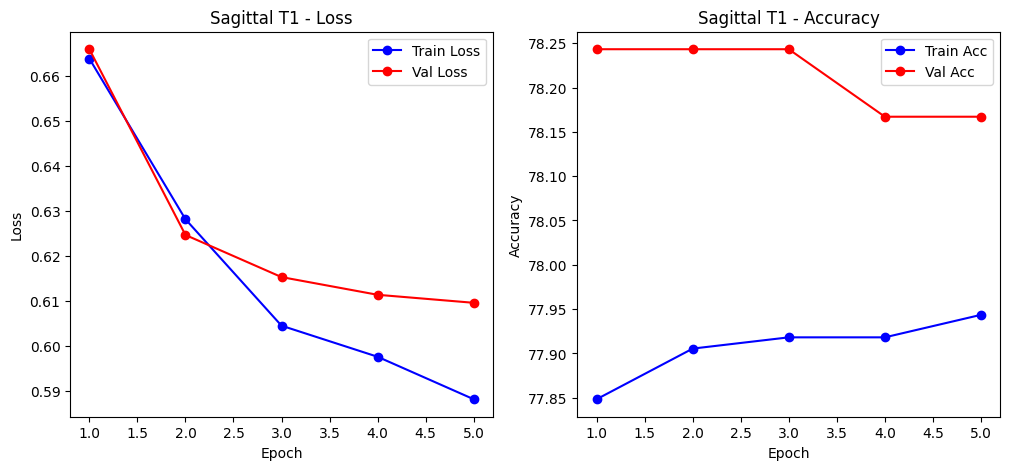

In [70]:
plot_metrics(train_losses_t1, val_losses_t1, train_acc_t1, val_acc_t1, 'Sagittal T1')

  0%|          | 0/196 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
  0%|          | 0/49 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
100%|██████████| 49/49 [00:13<00:00,  3.60batch/s, epoch=1]


Epoch 1, Train Loss: 0.7508, Train Acc: 71.68%, Val Loss: 0.7606, Val Acc: 71.94%


100%|██████████| 49/49 [00:12<00:00,  4.01batch/s, epoch=2]


Epoch 2, Train Loss: 0.7413, Train Acc: 71.61%, Val Loss: 0.7597, Val Acc: 71.94%


100%|██████████| 49/49 [00:09<00:00,  5.43batch/s, epoch=3]


Epoch 3, Train Loss: 0.7364, Train Acc: 71.61%, Val Loss: 0.7600, Val Acc: 71.94%


100%|██████████| 49/49 [00:08<00:00,  5.58batch/s, epoch=4]


Epoch 4, Train Loss: 0.7354, Train Acc: 71.61%, Val Loss: 0.7601, Val Acc: 71.94%


100%|██████████| 49/49 [00:11<00:00,  4.10batch/s, epoch=5]


Epoch 5, Train Loss: 0.7359, Train Acc: 71.61%, Val Loss: 0.7601, Val Acc: 71.94%


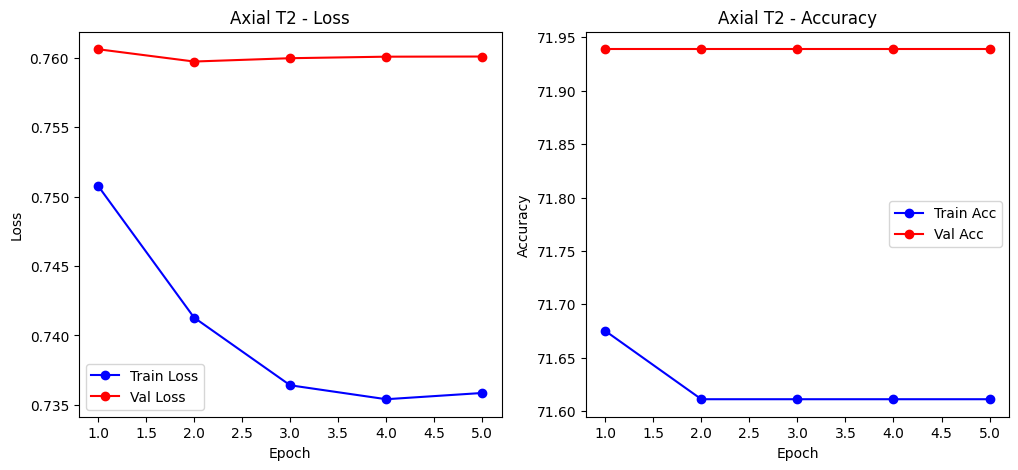

In [60]:
train_losses_t2, val_losses_t2, train_acc_t2, val_acc_t2 = train_model2(
    axial_t2_model, trainloader_t2, valloader_t2, len_train_t2, len_val_t2, optimizer_axial_t2, num_epochs=5)

plot_metrics(train_losses_t2, val_losses_t2, train_acc_t2, val_acc_t2, 'Axial T2')

  0%|          | 0/98 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
  0%|          | 0/25 [00:00<?, ?batch/s]C:\Users\rentt\AppData\Local\Temp\ipykernel_28548\3621499618.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels, dtype=torch.long).to(device)
100%|██████████| 25/25 [00:07<00:00,  3.18batch/s, epoch=1]


Epoch 1, Train Loss: 0.7791, Train Acc: 87.44%, Val Loss: 0.4867, Val Acc: 87.24%


100%|██████████| 25/25 [00:07<00:00,  3.36batch/s, epoch=2]


Epoch 2, Train Loss: 0.4601, Train Acc: 87.56%, Val Loss: 0.4587, Val Acc: 87.24%


100%|██████████| 25/25 [00:04<00:00,  5.25batch/s, epoch=3]


Epoch 3, Train Loss: 0.4126, Train Acc: 87.56%, Val Loss: 0.4487, Val Acc: 87.24%


100%|██████████| 25/25 [00:04<00:00,  5.28batch/s, epoch=4]


Epoch 4, Train Loss: 0.3952, Train Acc: 87.56%, Val Loss: 0.4439, Val Acc: 87.24%


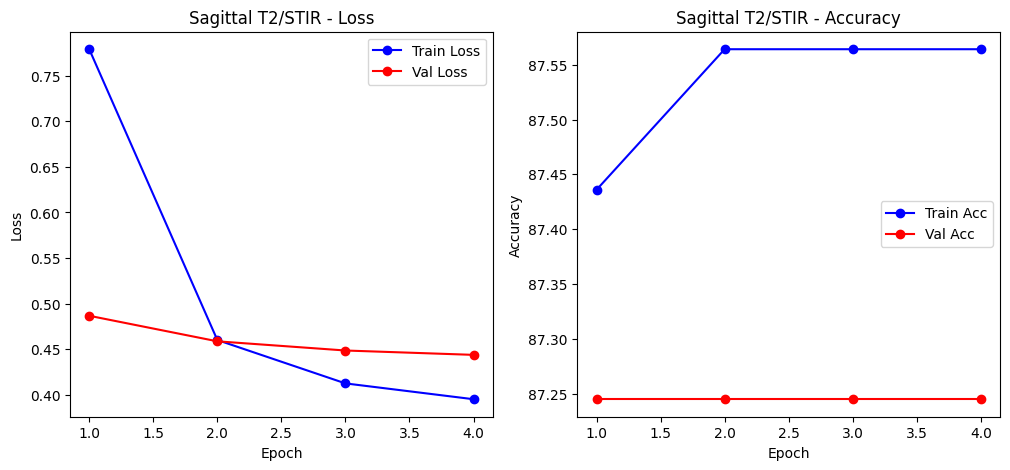

In [62]:
train_losses_t2stir, val_losses_t2stir, train_acc_t2stir, val_acc_t2stir = train_model2(
    sagittal_t2stir_model, trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir, optimizer_sagittal_t2stir, num_epochs=4)

plot_metrics(train_losses_t2stir, val_losses_t2stir, train_acc_t2stir, val_acc_t2stir, 'Sagittal T2/STIR')

  0%|          | 0/975 [00:00<?, ?batch/s]/tmp/ipykernel_23/942948466.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels,dtype=torch.long).to(device)
  0%|          | 0/244 [00:00<?, ?batch/s]/tmp/ipykernel_23/942948466.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels,dtype=torch.long).to(device)
100%|██████████| 244/244 [00:41<00:00,  5.92batch/s, epoch=1]


Epoch 1, Train Loss: 0.4928, Train Acc: 87.74%, Val Loss: 0.4613, Val Acc: 87.13%


100%|██████████| 244/244 [00:41<00:00,  5.88batch/s, epoch=2]


Epoch 2, Train Loss: 0.4653, Train Acc: 87.84%, Val Loss: 0.4642, Val Acc: 87.13%


100%|██████████| 244/244 [00:40<00:00,  6.08batch/s, epoch=3]


Epoch 3, Train Loss: 0.4499, Train Acc: 87.84%, Val Loss: 0.4592, Val Acc: 87.13%


100%|██████████| 244/244 [00:40<00:00,  6.10batch/s, epoch=4]


Epoch 4, Train Loss: 0.4475, Train Acc: 87.84%, Val Loss: 0.4582, Val Acc: 87.13%
Early stopping triggered after 4 epochs


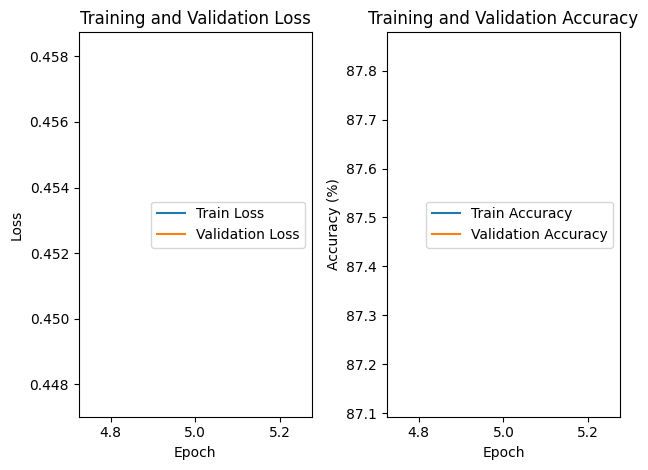

In [20]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(sagittal_t2stir_model, trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir, optimizer_sagittal_t2stir)
# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
torch.save(sagittal_t1_model.state_dict(), "alexnet_saggitalt1_model.pth")
torch.save(axial_t2_model.state_dict(), "alexnet_axial_t2_model.pth")
torch.save(sagittal_t2stir_model.state_dict(), "alexnet_sagittal_t2.pth")